In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
%tensorflow_version 1.x

Mounted at /content/drive
TensorFlow 1.x selected.


In [2]:
!pip install tiffile
!pip install csbdeep
!pip install scikit-image

In [7]:

import sys
import os

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import difflib
%config InlineBackend.figure_format = 'retina'
from matplotlib import cm
import glob
from tifffile import imread, imwrite
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
from csbdeep.models import Config, CARE
import skimage

from skimage import transform
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
from pathlib import Path

In [4]:
Masterdir = '/content/drive/My Drive/Images_For_FAQT/'
Savedir = '/content/drive/My Drive/Images_For_FAQT/UnRotated/'
Segmentationdir = '/content/drive/My Drive/Images_For_FAQT/PCA/'

PCAResults = Masterdir + '/MaskResults/'
Model_Dir = '/content/drive/My Drive/LeopoldLab/SegmentationModel/'
UNETSegmentationModelName = 'DeepWingSegmentationModelUNET'
UnetModel = CARE(config = None, name = UNETSegmentationModelName, basedir = Model_Dir)
Path(Savedir).mkdir(exist_ok = True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Loading network weights from 'weights_best.h5'.


In [5]:
def doubleplot(imageA, imageB, titleA, titleB, targetdir = None, File = None, plotTitle = None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    ax = axes.ravel()
    ax[0].imshow(imageA, cmap=cm.gray)
    ax[0].set_title(titleA)
    ax[0].set_axis_off()
    ax[1].imshow(imageB, cmap=plt.cm.nipy_spectral)
    ax[1].set_title(titleB)
    ax[1].set_axis_off()

    plt.tight_layout()
    plt.show()
    for a in ax:
      a.set_axis_off() 

/usr/local/lib/python3.7/dist-packages/csbdeep/models/base_model.py:255: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +


1.1002471762290988


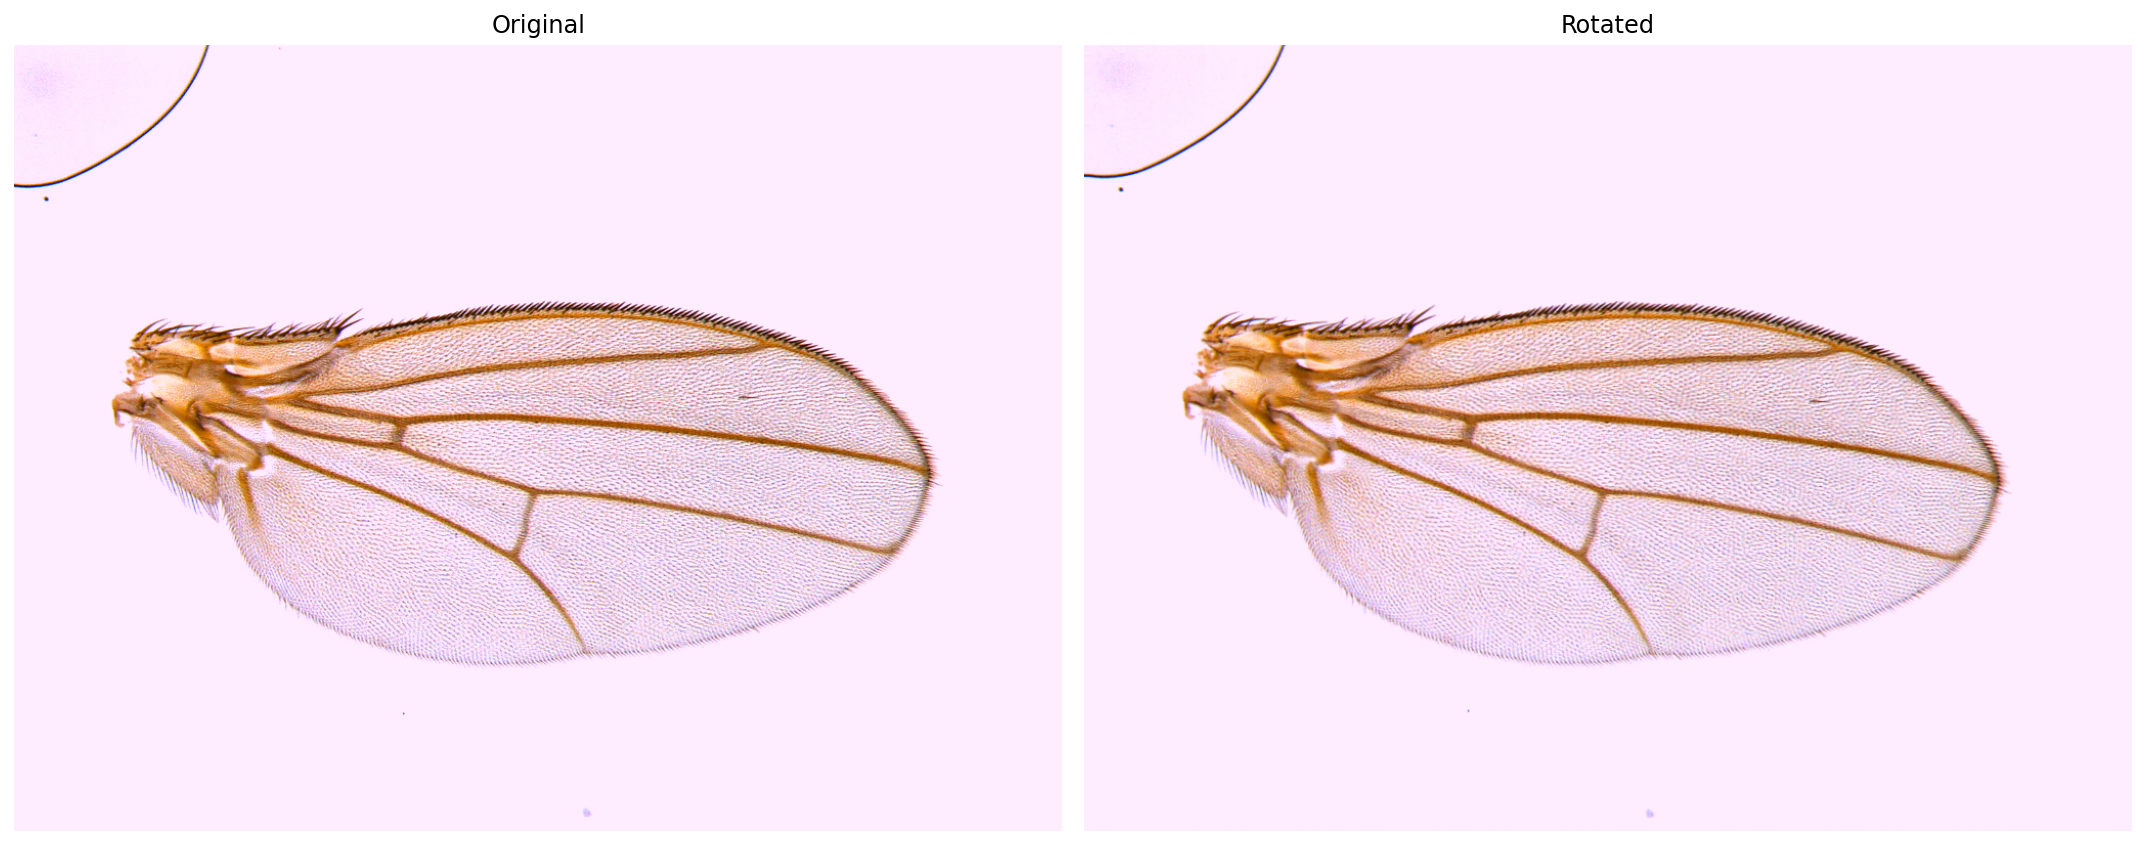

19.47848556699863


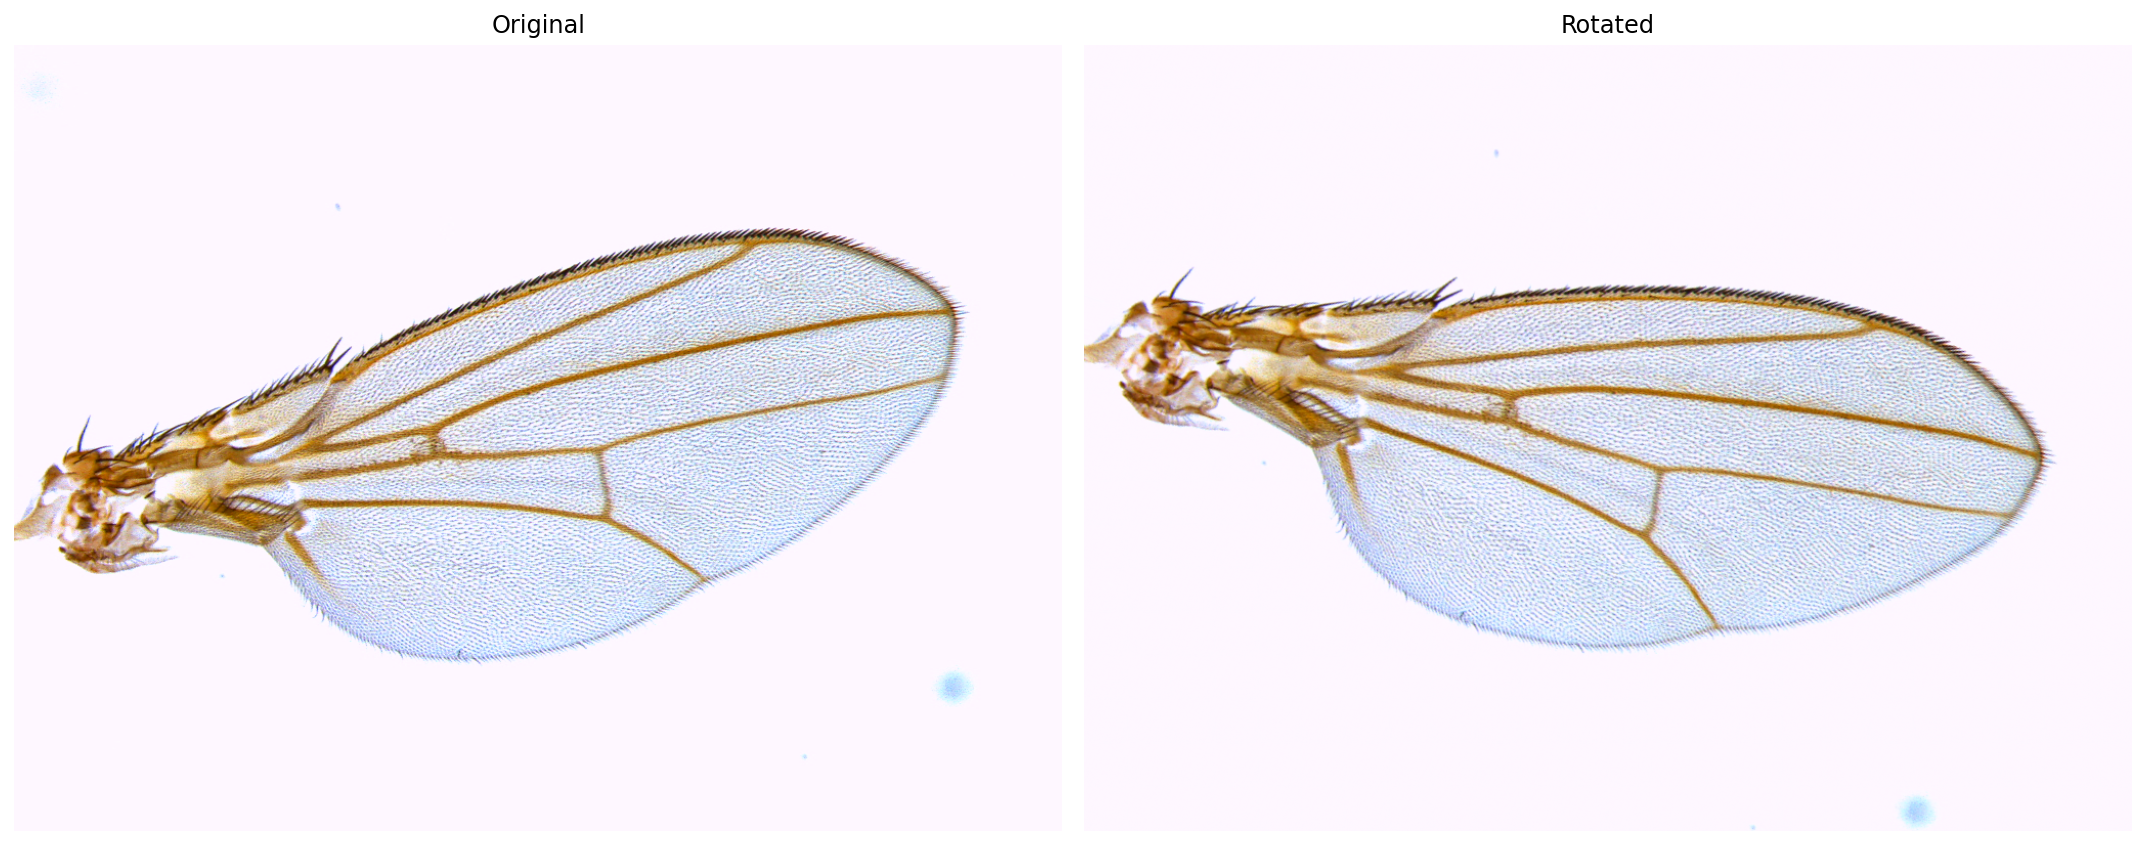

In [12]:
Raw_path = os.path.join(Masterdir, '*tif')
filesRaw = glob.glob(Raw_path)
filesRaw.sort
axes = 'YXC'

min_size = 15000
for fname in filesRaw:
            
            #Read image        
            image = imread(fname)
            Name = os.path.basename(os.path.splitext(fname)[0])

            #DO the segmentation
            Segmented = UnetModel.predict(image,axes)
            thresh = threshold_otsu(Segmented) 
            Binary = Segmented > thresh
            Filled = binary_fill_holes(Binary)
            Finalimage = remove_small_objects(Filled, min_size)
            Finalimage = Finalimage[:,:,0]
            y, x = np.nonzero(Finalimage)
            x = x - np.mean(x)
            y = y - np.mean(y)
            coords = np.vstack([x, y])

            cov = np.cov(coords)
            evals, evecs = np.linalg.eig(cov) 


            sort_indices = np.argsort(evals)[::-1]
            x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
            x_v2, y_v2 = evecs[:, sort_indices[1]]

            #Uncomment lines below to see the eigenvectors
            #scale = 20
            #plt.plot([x_v1*-scale*2, x_v1*scale*2],
                    #[y_v1*-scale*2, y_v1*scale*2], color='red')
            #plt.plot([x_v2*-scale, x_v2*scale],
                    #[y_v2*-scale, y_v2*scale], color='blue')
            
            #plt.axis('equal')
            #plt.gca().invert_yaxis()  # Match the image system with origin at top left
            #plt.show()
            theta1 = np.arctan((x_v1)/(y_v1)) 
            theta2 = np.arctan((x_v2)/(y_v2)) 
            theta2deg = theta2 * 180 / 3.14
            print(theta2deg)
            rotation_mat = np.matrix([[np.cos(theta2), -np.sin(theta2)],
                      [np.sin(theta2), np.cos(theta2)]])
            rotatedimage = transform.rotate(image,-theta2deg, resize = False, mode = "edge" )
            imwrite(Savedir + Name + '.tif', rotatedimage)
            doubleplot(image, rotatedimage, "Original", "Rotated")
